# tnc-edge-system-uptime

This notebook analyses the system uptime from looking at various system outputs.

### data sources

Vectors 1 (Internet test) and 3 (thalos mounted network dir) are designed to see if the network is working. These vectors are run on a regular interval.

The EM systems are expected to produce video on 5 minute intervals. This notebook also looks at the list of video files produced, parses the datetime, and uses that info to analyse system uptime.

THALOS also provided us with data files containing their Certus uptime reports.

### outputs

Several plots are produced to help visualize the analysis

Sunrise and Sunset are included as an alternative baseline.

Ultimately, this notebook produces an uptime percentage number for all trips, with 24/7 as a baseline and with daylight hours as a baseline.

In [ ]:
# aws_config = {
# 'aws_access_key_id':'XXXXXX',
# 'aws_secret_access_key':'XXXXXX',
# 'aws_session_token':'XXXXXX'
# }

aws_config = {}

aws_config["profile_name"] = "XXXXXX"
aws_config["region_name"] = "us-east-1"

import boto3

boto3.setup_default_session(**aws_config)

s3 = boto3.client("s3")

# s3.list_objects(Bucket='51-gema-dev-dp-raw' , Prefix='tnc_edge/')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [2]:
import pandas
import awswrangler
from datetime import datetime, timezone, timedelta
from dateutil import parser
import pytz


def display_full(x):
    pandas.set_option("display.max_rows", 1000)
    pandas.set_option("display.min_rows", 400)
    pandas.set_option("display.max_columns", None)
    pandas.set_option("display.width", 2000)
    pandas.set_option("display.float_format", "{:20,.2f}".format)
    pandas.set_option("display.max_colwidth", None)
    display(x)
    pandas.reset_option("display.max_rows")
    pandas.reset_option("display.max_columns")
    pandas.reset_option("display.width")
    pandas.reset_option("display.float_format")
    pandas.reset_option("display.max_colwidth")


In [3]:
sunrisesunset = pandas.read_csv("cr_sunrise_sunset.csv")
crtz = pytz.timezone("America/Costa_Rica")

# the following doesn't work for some reason?
# so I need to replace tz in a separate step
# sunrisesunset['sunrise'] = sunrisesunset.apply(lambda x: datetime.combine(parser.parse(x['date']).date(),parser.parse(x['sunrise']).time()).replace(tzinfo=crtz), axis=1)
# sunrisesunset['sunset'] = sunrisesunset.apply(lambda x: datetime.combine(parser.parse(x['date']).date(),parser.parse(x['sunset']).time()).replace(tzinfo=crtz), axis=1)

sunrisesunset["sunrise"] = sunrisesunset.apply(
    lambda x: datetime.combine(parser.parse(x["date"]).date(), parser.parse(x["sunrise"]).time()),
    axis=1,
)
sunrisesunset["sunset"] = sunrisesunset.apply(
    lambda x: datetime.combine(parser.parse(x["date"]).date(), parser.parse(x["sunset"]).time()),
    axis=1,
)

sunrisesunset["sunrise"] = sunrisesunset["sunrise"].map(lambda x: x.replace(tzinfo=crtz))
sunrisesunset["sunset"] = sunrisesunset["sunset"].map(lambda x: x.replace(tzinfo=crtz))

sunrisesunset

,date,sunrise,sunset
0,2024-01-01,2024-01-01 06:37:00-06:00,2024-01-01 17:33:00-06:00
1,2024-01-02,2024-01-02 06:37:00-06:00,2024-01-02 17:33:00-06:00
2,2024-01-03,2024-01-03 06:37:00-06:00,2024-01-03 17:34:00-06:00
3,2024-01-04,2024-01-04 06:37:00-06:00,2024-01-04 17:35:00-06:00
4,2024-01-05,2024-01-05 06:38:00-06:00,2024-01-05 17:35:00-06:00
...,...,...,...
101,2024-04-11,2024-04-11 06:46:00-06:00,2024-04-11 19:19:00-06:00
102,2024-04-12,2024-04-12 06:45:00-06:00,2024-04-12 19:19:00-06:00
103,2024-04-13,2024-04-13 06:44:00-06:00,2024-04-13 19:19:00-06:00
104,2024-04-14,2024-04-14 06:43:00-06:00,2024-04-14 19:19:00-06:00


In [ ]:
s = awswrangler.athena.read_sql_query(
    f"SELECT brancol_v1_tests.* from brancol_v1_tests where vector_id in ('1', '3') and datetime > '2024-01-01' order by id asc limit 10000",
    database="tnc_edge",
)
s.datetime = pandas.to_datetime(s.datetime, utc=True)
display(s)

In [119]:
s["lan_errors"] = s.loc[s["vector_id"] == "3"]["score"]
s["wan_errors"] = s.loc[s["vector_id"] == "1"]["score"]
s = s.drop(columns=["score"])
s

,id,name,type,vector_id,detail,datetime,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,lan_errors,wan_errors
0,17992,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,<NA>,2024-01-03 15:50:39.344279+00:00,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,0.0,<NA>
1,17993,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,<NA>,2024-01-03 16:10:39.649228+00:00,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,0.0,<NA>
2,17996,internet test at 2024-01-03 16:20:39Z,<NA>,1,<NA>,2024-01-03 16:20:39.459919+00:00,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,<NA>,0.0
3,17998,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,<NA>,2024-01-03 16:20:50.735407+00:00,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,0.0,<NA>
4,18001,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,<NA>,2024-01-03 16:30:50.891635+00:00,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,0.0,<NA>
5,18004,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,<NA>,2024-01-03 16:40:51.040902+00:00,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,0.0,<NA>
6,18008,internet test at 2024-01-03 16:50:50Z,<NA>,1,<NA>,2024-01-03 16:50:50.667511+00:00,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,<NA>,0.0
7,18010,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,<NA>,2024-01-03 16:51:00.588757+00:00,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,0.0,<NA>
8,18013,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,<NA>,2024-01-03 17:01:00.749743+00:00,<NA>,<NA>,2024-01-04 16:22:10,2024/1/4/1704385322-0.csv,831dcf96-e6af-4a22-84d1-7e616e231d53,2024,1,4,0.0,<NA>
9,18016,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,<NA>,2024-01-03 17:11:00.895999+00:00,<NA>,<NA>,2024-01-04 16:22:10,2024/1/4/1704385322-0.csv,831dcf96-e6af-4a22-84d1-7e616e231d53,2024,1,4,0.0,<NA>


In [378]:
from dateutil.parser import parse as parse_dt
from datetime import datetime, timedelta, timezone, date, time
# import datetime


pandas.core.dtypes.dtypes.DatetimeTZDtype

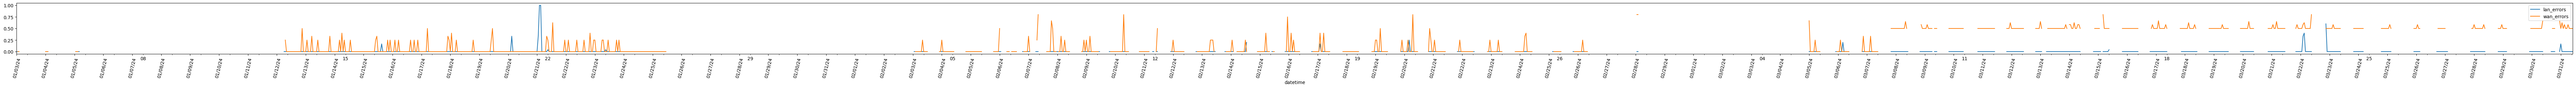

In [120]:
# dir(s['score'].dtype.num)
display(type(s["datetime"].dtype))
if not s["datetime"].dtype == "datetime64":
    s["datetime"] = pandas.to_datetime(s["datetime"], utc=True)
# s['datetime'] = pandas.to_datetime(s['datetime'], utc=True)


# if not pandas.api.types.is_numeric_dtype(s['score'].dtype):
#     s['score'] = pandas.to_numeric(s['score'])
if not pandas.api.types.is_numeric_dtype(s["lan_errors"].dtype):
    s["lan_errors"] = pandas.to_numeric(s["lan_errors"])
if not pandas.api.types.is_numeric_dtype(s["wan_errors"].dtype):
    s["wan_errors"] = pandas.to_numeric(s["wan_errors"])

# display(s)

s_gb = s.groupby("datetime").mean(numeric_only=True)

# display(s_gb.index)
cnt_ts = s_gb.resample(timedelta(minutes=60)).mean()

ax = cnt_ts.plot(figsize=(100, 2))
xticks = pandas.date_range(start=cnt_ts.index.min(), end=cnt_ts.index.max(), freq=timedelta(days=1))
# display(xticks)
ax.set_xticks(xticks.to_pydatetime())
ax.set_xticklabels([x.strftime("%D") for x in xticks], rotation=77)
# ax.xticks(rotation=90);
display(ax)
# ax

In [574]:
branc_box_cam1_filedatetimes_df = pandas.read_csv(
    "brancol_box_cam1_filedatetimes.txt", names=["datetime"]
)
branc_box_cam1_filedatetimes_df["datetime"] = pandas.to_datetime(
    branc_box_cam1_filedatetimes_df["datetime"], utc=True
)
branc_box_cam1_filedatetimes_df["cam1"] = 1
branc_box_cam1_filedatetimes_df.index = branc_box_cam1_filedatetimes_df["datetime"]
branc_box_cam1_filedatetimes_df = branc_box_cam1_filedatetimes_df[["cam1"]]
branc_box_cam2_filedatetimes_df = pandas.read_csv(
    "brancol_box_cam2_filedatetimes.txt", names=["datetime"]
)
branc_box_cam2_filedatetimes_df["datetime"] = pandas.to_datetime(
    branc_box_cam2_filedatetimes_df["datetime"], utc=True
)
branc_box_cam2_filedatetimes_df["cam2"] = 1
branc_box_cam2_filedatetimes_df.index = branc_box_cam2_filedatetimes_df["datetime"]
branc_box_cam2_filedatetimes_df = branc_box_cam2_filedatetimes_df[["cam2"]]

branc_box_filedatetimes_df = branc_box_cam1_filedatetimes_df.join(
    branc_box_cam2_filedatetimes_df, how="outer"
)
branc_box_filedatetimes_df = branc_box_filedatetimes_df.loc["2024"]
branc_box_filedatetimes_df = branc_box_filedatetimes_df.fillna(0)

branc_box_filedatetimes_df.to_pickle("brancol_box_filedatetimes.pickle")

stp_box_cam1_filedatetimes_df = pandas.read_csv(
    "stpatrick_box_cam1_filedatetimes.txt", names=["datetime"]
)
stp_box_cam1_filedatetimes_df["datetime"] = pandas.to_datetime(
    stp_box_cam1_filedatetimes_df["datetime"], utc=True
)
stp_box_cam1_filedatetimes_df["cam1"] = 1
stp_box_cam1_filedatetimes_df.index = stp_box_cam1_filedatetimes_df["datetime"]
stp_box_cam1_filedatetimes_df = stp_box_cam1_filedatetimes_df[["cam1"]]

stp_box_cam2_filedatetimes_df = pandas.read_csv(
    "stpatrick_box_cam2_filedatetimes.txt", names=["datetime"]
)
stp_box_cam2_filedatetimes_df["datetime"] = pandas.to_datetime(
    stp_box_cam2_filedatetimes_df["datetime"], utc=True
)
stp_box_cam2_filedatetimes_df["cam2"] = 1
stp_box_cam2_filedatetimes_df.index = stp_box_cam2_filedatetimes_df["datetime"]
stp_box_cam2_filedatetimes_df = stp_box_cam2_filedatetimes_df[["cam2"]]


stp_box_filedatetimes_df = stp_box_cam1_filedatetimes_df.join(
    stp_box_cam2_filedatetimes_df, how="outer"
)
stp_box_filedatetimes_df = stp_box_filedatetimes_df.loc["2024"]
stp_box_filedatetimes_df = stp_box_filedatetimes_df.fillna(0)

stp_box_filedatetimes_df.to_pickle("stpatrick_box_filedatetimes.pickle")


,cam1,cam2
datetime,,
2024-01-03 15:50:00+00:00,1.0,1.0
2024-01-03 15:55:00+00:00,0.0,1.0
2024-01-03 16:00:00+00:00,0.0,1.0
2024-01-03 16:05:00+00:00,1.0,1.0
2024-01-03 16:10:00+00:00,1.0,1.0
2024-01-03 16:15:00+00:00,1.0,1.0
2024-01-03 16:20:00+00:00,1.0,1.0
2024-01-03 16:25:00+00:00,0.0,1.0
2024-01-03 16:30:00+00:00,1.0,1.0


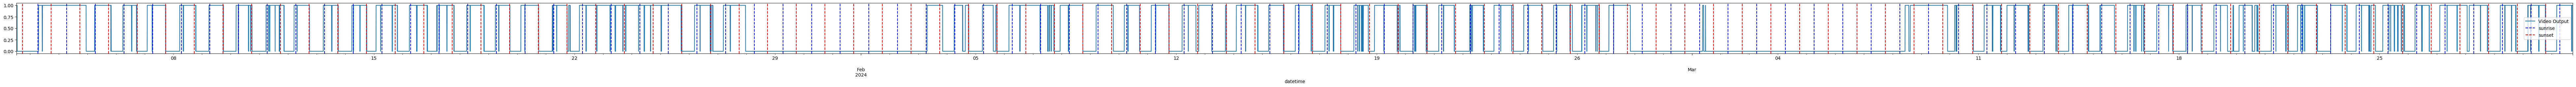

In [159]:
stp_box_filedatetimes_df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle").rename(
    columns={"cam1": "stp_cam1", "cam2": "stp_cam2"}
)
branc_box_filedatetimes_df = pandas.read_pickle("brancol_box_filedatetimes.pickle").rename(
    columns={"cam1": "bra_cam1", "cam2": "bra_cam2"}
)

# aa = branc_box_filedatetimes_df.join(stp_box_filedatetimes_df, how='outer')
# aa = aa.fillna(0)

# aa
# branc_box_filedatetimes_df

df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle")
df = df.apply(lambda x: x.cam1 > 0 and x.cam2 > 0, axis=1)
p = df.resample(timedelta(minutes=5)).sum()

# p = p.loc[p.index >= '2024-02-17 00:00:00-06']
# p = p.loc[p.index <= '2024-02-21 00:00:00-06']
p.index = p.index.map(lambda x: x.tz_convert("America/Costa_Rica"))
# p.index
ax = p.plot(figsize=(100, 2), label="Video Output")
# display_full(rs['2023-12-27 19'])

first = True
for time in sunrisesunset["sunrise"]:
    ax.axvline(
        x=pandas.to_datetime(time), color="b", linestyle="--", label="sunrise" if first else None
    )
    first = False
first = True
for time in sunrisesunset["sunset"]:
    ax.axvline(
        x=pandas.to_datetime(time), color="r", linestyle="--", label="sunset" if first else None
    )
    first = False

# Show the plot
ax.legend()

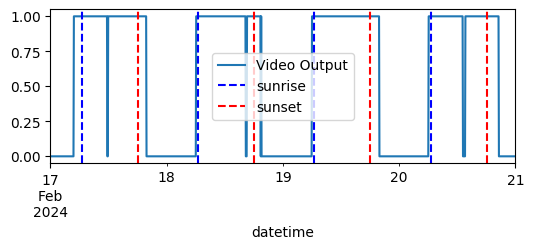

In [157]:
stp_box_filedatetimes_df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle").rename(
    columns={"cam1": "stp_cam1", "cam2": "stp_cam2"}
)
branc_box_filedatetimes_df = pandas.read_pickle("brancol_box_filedatetimes.pickle").rename(
    columns={"cam1": "bra_cam1", "cam2": "bra_cam2"}
)

# aa = branc_box_filedatetimes_df.join(stp_box_filedatetimes_df, how='outer')
# aa = aa.fillna(0)

# aa
# branc_box_filedatetimes_df

df = pandas.read_pickle("brancol_box_filedatetimes.pickle")
df = df.apply(lambda x: x.cam1 > 0 and x.cam2 > 0, axis=1)
p = df.resample(timedelta(minutes=5)).sum()

p = p.loc[p.index >= "2024-02-17 00:00:00-06"]
p = p.loc[p.index <= "2024-02-21 00:00:00-06"]
p.index = p.index.map(lambda x: x.tz_convert("America/Costa_Rica"))
# p.index
ax = p.plot(figsize=(6, 2), label="Video Output")
# display_full(rs['2023-12-27 19'])

sunrises = sunrisesunset["sunrise"].loc[
    (sunrisesunset["sunrise"] > "2024-02-17") & (sunrisesunset["sunrise"] < "2024-02-21")
]

sunsets = sunrisesunset["sunset"].loc[
    (sunrisesunset["sunrise"] > "2024-02-17") & (sunrisesunset["sunrise"] < "2024-02-21")
]
first = True
for time in sunrises:
    ax.axvline(
        x=pandas.to_datetime(time), color="b", linestyle="--", label="sunrise" if first else None
    )
    first = False
first = True
for time in sunsets:
    ax.axvline(
        x=pandas.to_datetime(time), color="r", linestyle="--", label="sunset" if first else None
    )
    first = False

# Show the plot
ax.legend()

Text(0.5, 0, '')

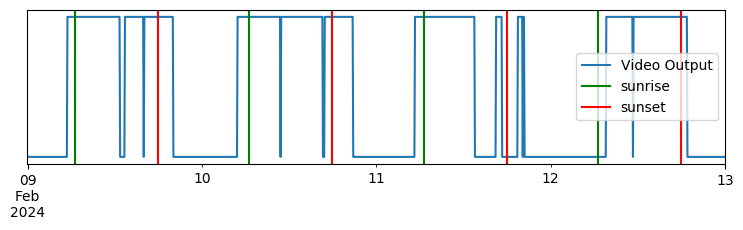

In [173]:
stp_box_filedatetimes_df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle").rename(
    columns={"cam1": "stp_cam1", "cam2": "stp_cam2"}
)
branc_box_filedatetimes_df = pandas.read_pickle("brancol_box_filedatetimes.pickle").rename(
    columns={"cam1": "bra_cam1", "cam2": "bra_cam2"}
)

# aa = branc_box_filedatetimes_df.join(stp_box_filedatetimes_df, how='outer')
# aa = aa.fillna(0)

# aa
# branc_box_filedatetimes_df

df = pandas.read_pickle("brancol_box_filedatetimes.pickle")
df = df.apply(lambda x: x.cam1 > 0 and x.cam2 > 0, axis=1)
p = df.resample(timedelta(minutes=5)).sum()

p = p.loc[p.index >= "2024-02-09 00:00:00-06"]
p = p.loc[p.index <= "2024-02-13 00:00:00-06"]
p.index = p.index.map(lambda x: x.tz_convert("America/Costa_Rica"))
# p.index
ax = p.plot(figsize=(9, 2), label="Video Output")
# display_full(rs['2023-12-27 19'])

sunrises = sunrisesunset["sunrise"].loc[
    (sunrisesunset["sunrise"] > "2024-02-09") & (sunrisesunset["sunrise"] < "2024-02-13")
]

sunsets = sunrisesunset["sunset"].loc[
    (sunrisesunset["sunrise"] > "2024-02-09") & (sunrisesunset["sunrise"] < "2024-02-13")
]
first = True
for time in sunrises:
    ax.axvline(
        x=pandas.to_datetime(time), color="g", linestyle="-", label="sunrise" if first else None
    )
    first = False
first = True
for time in sunsets:
    ax.axvline(
        x=pandas.to_datetime(time), color="r", linestyle="-", label="sunset" if first else None
    )
    first = False

ax.legend()
ax.set_yticks([])
ax.set_xlabel("")

In [203]:
stp_box_filedatetimes_df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle").rename(
    columns={"cam1": "stp_cam1", "cam2": "stp_cam2"}
)
branc_box_filedatetimes_df = pandas.read_pickle("brancol_box_filedatetimes.pickle").rename(
    columns={"cam1": "bra_cam1", "cam2": "bra_cam2"}
)

# aa = branc_box_filedatetimes_df.join(stp_box_filedatetimes_df, how='outer')
# aa = aa.fillna(0)

# aa
# branc_box_filedatetimes_df

recorded_sum = 0
triptime_sum = 0


df = pandas.read_pickle("brancol_box_filedatetimes.pickle")
df = df.apply(lambda x: 1 if x.cam1 > 0 and x.cam2 > 0 else 0, axis=1)
brancol_trip1_startend = (
    parser.parse("2024-01-05 16:14:42Z"),
    parser.parse("2024-01-26 01:35:17Z"),
)
brancoltrip1 = df.loc[df.index > brancol_trip1_startend[0]]
brancoltrip1 = brancoltrip1.loc[brancoltrip1.index < brancol_trip1_startend[1]]
brancoltrip1.loc[brancol_trip1_startend[0]] = 0
brancoltrip1.loc[brancol_trip1_startend[1]] = 0
# brancoltrip1
p = brancoltrip1.resample(timedelta(minutes=5)).sum()
recorded_sum += p.sum()
triptime_sum += len(p)
display("brancol trip 1: ", p.sum() / len(p))

brancol_trip2_startend = (
    parser.parse("2024-02-03 17:16:47Z"),
    parser.parse("2024-02-26 23:32:03Z") + timedelta(hours=7.0966),
)

brancoltrip2 = df.loc[df.index > brancol_trip2_startend[0]]
brancoltrip2 = brancoltrip2.loc[brancoltrip2.index < brancol_trip2_startend[1]]
brancoltrip2.loc[brancol_trip2_startend[0]] = 0
brancoltrip2.loc[brancol_trip2_startend[1]] = 0
# brancoltrip1
p = brancoltrip2.resample(timedelta(minutes=5)).sum()
recorded_sum += p.sum()
triptime_sum += len(p)
display("brancol trip 2: ", p.sum() / len(p))


brancol_trip3_startend = (
    parser.parse("2024-03-05 15:26:13Z"),
    parser.parse("2024-04-01 01:21:47Z") + timedelta(hours=8.4725),
)

brancoltrip3 = df.loc[df.index > brancol_trip3_startend[0]]
brancoltrip3 = brancoltrip3.loc[brancoltrip3.index < brancol_trip3_startend[1]]
brancoltrip3.loc[brancol_trip3_startend[0]] = 0
brancoltrip3.loc[brancol_trip3_startend[1]] = 0
# brancoltrip3
p = brancoltrip3.resample(timedelta(minutes=5)).sum()
recorded_sum += p.sum()
triptime_sum += len(p)
display("brancol trip 3: ", p.sum() / len(p))


df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle")
df = df.apply(lambda x: 1 if x.cam1 > 0 and x.cam2 > 0 else 0, axis=1)

stpatrick_trip1_startend = (
    parser.parse("2024-01-03 13:22:25Z"),
    parser.parse("2024-01-28 06:40:04Z"),
)


stpatricktrip1 = df.loc[df.index > stpatrick_trip1_startend[0]]
stpatricktrip1 = stpatricktrip1.loc[stpatricktrip1.index < stpatrick_trip1_startend[1]]
stpatricktrip1.loc[stpatrick_trip1_startend[0]] = 0
stpatricktrip1.loc[stpatrick_trip1_startend[1]] = 0
# brancoltrip3
p = stpatricktrip1.resample(timedelta(minutes=5)).sum()
# display_full(p)
recorded_sum += p.sum()
triptime_sum += len(p)
display("stpatrick trip 1: ", p.sum() / len(p))

# 10.9 miles / 6 knots = 1.57 hours
stpatrick_trip2_startend = (
    parser.parse("2024-02-03 13:44:11Z"),
    parser.parse("2024-02-28 03:42:55Z") + timedelta(hours=1.578),
)

stpatricktrip2 = df.loc[df.index > stpatrick_trip2_startend[0]]
stpatricktrip2 = stpatricktrip2.loc[stpatricktrip2.index < stpatrick_trip2_startend[1]]
stpatricktrip2.loc[stpatrick_trip2_startend[0]] = 0
stpatricktrip2.loc[stpatrick_trip2_startend[1]] = 0
# brancoltrip3
p = stpatricktrip2.resample(timedelta(minutes=5)).sum()
recorded_sum += p.sum()
triptime_sum += len(p)
display("stpatrick trip 2: ", p.sum() / len(p))

display("recording uptime for all trips:")
display(f"{(recorded_sum / triptime_sum * 100):.1f}%")

'brancol trip 1: '

0.9800817160367722

'brancol trip 2: '

0.5510685335298452

'brancol trip 3: '

0.49571984435797667

'stpatrick trip 1: '

0.65033000983008

'stpatrick trip 2: '

0.6001408450704225

'recording uptime for all trips:'

'64.2%'

In [237]:
ts = pandas.DataFrame()
ts["ts"] = [
    sunrisesunset.index.min().replace(tzinfo=crtz),
    sunrisesunset.index.max().replace(tzinfo=crtz),
]

ts.index = ts["ts"]
ts = ts.resample(timedelta(minutes=5)).sum()
type(sunrisesunset.index[0])
ts["is_daytime"] = ts.index.map(
    lambda x: sunrisesunset.loc[pandas.Timestamp(x.date())]["sunrise"] < x
    and sunrisesunset.loc[pandas.Timestamp(x.date())]["sunset"] > x
)
is_daytime = ts

In [512]:
stp_box_filedatetimes_df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle").rename(
    columns={"cam1": "stp_cam1", "cam2": "stp_cam2"}
)
branc_box_filedatetimes_df = pandas.read_pickle("brancol_box_filedatetimes.pickle").rename(
    columns={"cam1": "bra_cam1", "cam2": "bra_cam2"}
)

# aa = branc_box_filedatetimes_df.join(stp_box_filedatetimes_df, how='outer')
# aa = aa.fillna(0)

# aa
# branc_box_filedatetimes_df

recorded_sum = 0
triptime_sum = 0


df = pandas.read_pickle("brancol_box_filedatetimes.pickle")
df["bothcams"] = df.apply(lambda x: 1 if x.cam1 > 0 and x.cam2 > 0 else 0, axis=1)
brancol_trip1_startend = (
    parser.parse("2024-01-05 16:14:42Z"),
    parser.parse("2024-01-26 01:35:17Z"),
)
brancol_trip2_startend = (
    parser.parse("2024-02-03 17:16:47Z"),
    parser.parse("2024-02-26 23:32:03Z") + timedelta(hours=7.0966),
)
brancol_trip3_startend = (
    parser.parse("2024-03-05 15:26:13Z"),
    parser.parse("2024-04-01 01:21:47Z") + timedelta(hours=8.4725),
)
df.loc[brancol_trip1_startend[0]] = 0
df.loc[brancol_trip3_startend[1]] = 0
df = df.resample(timedelta(minutes=5)).sum()
df = df.loc[
    (df.index > brancol_trip1_startend[0]) & (df.index < brancol_trip1_startend[1])
    | (df.index > brancol_trip2_startend[0]) & (df.index < brancol_trip2_startend[1])
    | (df.index > brancol_trip3_startend[0]) & (df.index < brancol_trip3_startend[1])
]


df = df.join(is_daytime)

df = df.loc[df.is_daytime]
display("brancol bothcams upimecount", df["bothcams"].sum())
display("brancol bothcams daytimecount", len(df["bothcams"]))
display("brancol uptime during sunrisesunset", df["bothcams"].sum() / len(df["bothcams"]))

numeratorsum = df["bothcams"].sum()
denominatorsum = len(df["bothcams"])


df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle")
df["bothcams"] = df.apply(lambda x: 1 if x.cam1 > 0 and x.cam2 > 0 else 0, axis=1)
stpatrick_trip1_startend = (
    parser.parse("2024-01-03 13:22:25Z"),
    parser.parse("2024-01-28 06:40:04Z"),
)
stpatrick_trip2_startend = (
    parser.parse("2024-02-03 13:44:11Z"),
    parser.parse("2024-02-28 03:42:55Z") + timedelta(hours=1.578),
)
df.loc[stpatrick_trip1_startend[0]] = 0
df.loc[stpatrick_trip2_startend[1]] = 0
df = df.resample(timedelta(minutes=5)).sum()
df = df.loc[
    (df.index > stpatrick_trip1_startend[0]) & (df.index < stpatrick_trip1_startend[1])
    | (df.index > stpatrick_trip2_startend[0]) & (df.index < stpatrick_trip2_startend[1])
]


df = df.join(is_daytime)

df = df.loc[df.is_daytime]

display("stpatrick uptime during sunrisesunset", df["bothcams"].sum() / len(df["bothcams"]))

numeratorsum += df["bothcams"].sum()
denominatorsum += len(df["bothcams"])


display("alltrips uptime during sunrisesunset", numeratorsum / denominatorsum)

'brancol bothcams upimecount'

8779

'brancol bothcams daytimecount'

9862

'brancol uptime during sunrisesunset'

0.8901845467450822

'stpatrick uptime during sunrisesunset'

0.9385574354407836

'alltrips uptime during sunrisesunset'

0.9098192771084337

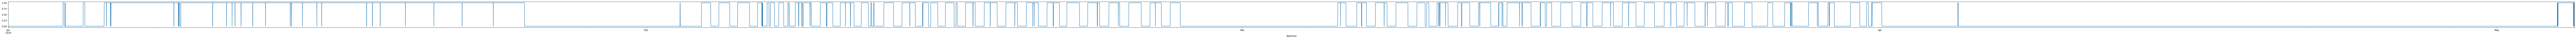

In [591]:
import io
import re


brancol_fname = "thalos_uptime_logs/sessions_brancol.csv"
# stpatrick_fname = 'thalos_uptime_logs/sessions_saintpatrick.csv'


r = re.compile("^\d+(, .*){8}")
brancol_lines = []
with open(brancol_fname) as brancol_f:
    for l in brancol_f.readlines():
        if r.match(l):
            brancol_lines.append(l)
#     print(type(brancol_f), dir(brancol_f))

# display(brancol_lines)

thalos_uptime_logs_brancol = pandas.read_csv(
    io.StringIO("".join(brancol_lines)),
    names=["id", "datetime", "boat", "certus", "status", "i", "j", "name", "ip"],
)

# thalos_uptime_logs_stpatrick = pandas.read_csv()

thalos_uptime_logs_brancol["datetime"] = pandas.to_datetime(
    thalos_uptime_logs_brancol["datetime"], utc=True
)
thalos_uptime_logs_brancol = thalos_uptime_logs_brancol.loc[
    thalos_uptime_logs_brancol["datetime"] > "2024-01-01"
]

thalos_uptime_logs_brancol.index = thalos_uptime_logs_brancol["datetime"]

# display(thalos_uptime_logs_brancol.index[4] )

# display(thalos_uptime_logs_brancol.loc[parser.parse('2024-01-04 15:22:07')])

thalos_uptime_logs_brancol.loc[parser.parse("2024-01-01 00:00Z")] = [
    0,
    parser.parse("2024-01-01"),
    " brancol",
    " cer1",
    " down",
    0,
    0,
    " pop-prd-pthalos000",
    " ",
]

# dir(thalos_uptime_logs_brancol.resample(timedelta(minutes=5)))
thalos_brancol_ts_df = thalos_uptime_logs_brancol.resample(timedelta(minutes=5)).last()
# u
thalos_brancol_ts_df["status"] = thalos_brancol_ts_df["status"].ffill()
thalos_brancol_ts_df["up"] = thalos_brancol_ts_df["status"].map(lambda x: 1 if x == " up" else 0)

thalos_brancol_ts_df.to_pickle("thaloslogs_brancol_uptime_ts_df.pickle")

thalos_brancol_ts_df["up"].plot(figsize=(200, 2))

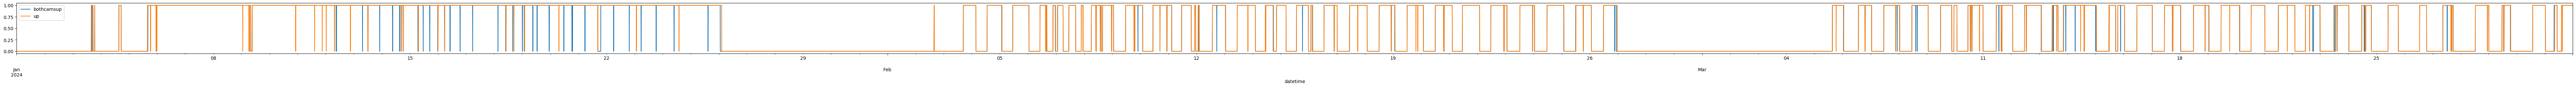

In [580]:
brancol_file_uptime = pandas.read_pickle("brancol_box_filedatetimes.pickle")
brancol_file_uptime.loc[parser.parse("2024-01-01 00:00Z")] = [0, 0]
brancol_file_uptime["bothcamsup"] = brancol_file_uptime.apply(
    lambda x: x.cam1 > 0 and x.cam2 > 0, axis=1
)
# display(stpatrick_file_uptime)
p = brancol_file_uptime.resample(timedelta(minutes=5)).last()
p["bothcamsup"] = p["bothcamsup"].fillna(0)

# p = p.loc[p.index >= '2024-02-17 00:00:00-06']
# p = p.loc[p.index <= '2024-02-21 00:00:00-06']
# p.index = p.index.map(lambda x: x.tz_convert('America/Costa_Rica'))

p = p.join(thalos_brancol_ts_df["up"])
p[["bothcamsup", "up"]].plot(figsize=(100, 2))

In [585]:
disparities = p.loc[p["bothcamsup"] + p["up"] == 1]
disparities.sum()

cam1          107.0
cam2          105.0
bothcamsup     57.0
up            232.0
dtype: float64

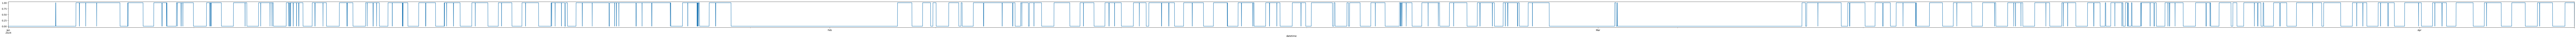

In [593]:
import io
import re


# brancol_fname = 'thalos_uptime_logs/sessions_brancol.csv'
stpatrick_fname = "thalos_uptime_logs/sessions_saintpatrick.csv"


r = re.compile("^\d+(, .*){8}")
stpatrick_lines = []
with open(stpatrick_fname) as stpatrick_f:
    for l in stpatrick_f.readlines():
        if r.match(l):
            stpatrick_lines.append(l)
#     print(type(brancol_f), dir(brancol_f))

# display(brancol_lines)

thalos_uptime_logs_stpatrick = pandas.read_csv(
    io.StringIO("".join(stpatrick_lines)),
    names=["id", "datetime", "boat", "certus", "status", "i", "j", "name", "ip"],
)

# thalos_uptime_logs_stpatrick = pandas.read_csv()

thalos_uptime_logs_stpatrick["datetime"] = pandas.to_datetime(
    thalos_uptime_logs_stpatrick["datetime"], utc=True
)
thalos_uptime_logs_stpatrick = thalos_uptime_logs_stpatrick.loc[
    thalos_uptime_logs_stpatrick["datetime"] > "2024-01-01"
]

thalos_uptime_logs_stpatrick.index = thalos_uptime_logs_stpatrick["datetime"]

# display(thalos_uptime_logs_brancol.index[4] )

# display(thalos_uptime_logs_brancol.loc[parser.parse('2024-01-04 15:22:07')])

thalos_uptime_logs_stpatrick.loc[parser.parse("2024-01-01 00:00Z")] = [
    0,
    parser.parse("2024-01-01"),
    " saintpatrick",
    " cer1",
    " down",
    0,
    0,
    " pop-prd-pthalos000",
    " ",
]

# dir(thalos_uptime_logs_brancol.resample(timedelta(minutes=5)))
thalos_stpatrick_ts_df = thalos_uptime_logs_stpatrick.resample(timedelta(minutes=5)).last()
# u
thalos_stpatrick_ts_df["status"] = thalos_stpatrick_ts_df["status"].ffill()
thalos_stpatrick_ts_df["up"] = thalos_stpatrick_ts_df["status"].map(
    lambda x: 1 if x == " up" else 0
)

thalos_stpatrick_ts_df.to_pickle("thaloslogs_stpatrick_uptime_ts_df.pickle")

thalos_stpatrick_ts_df["up"].plot(figsize=(200, 2))

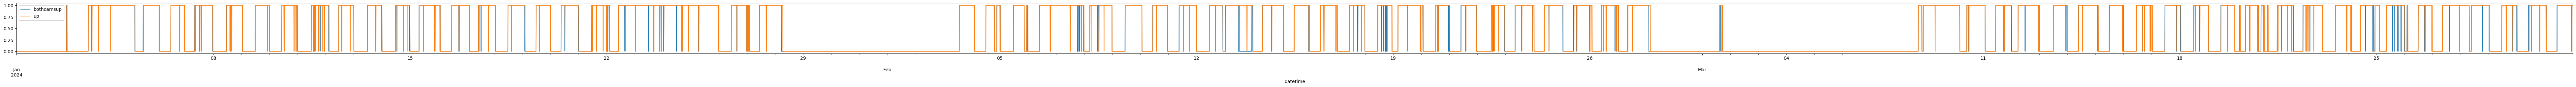

In [587]:
stpatrick_file_uptime = pandas.read_pickle("stpatrick_box_filedatetimes.pickle")
stpatrick_file_uptime.loc[parser.parse("2024-01-01 00:00Z")] = [0, 0]
stpatrick_file_uptime["bothcamsup"] = stpatrick_file_uptime.apply(
    lambda x: x.cam1 > 0 and x.cam2 > 0, axis=1
)
# display(stpatrick_file_uptime)
q = stpatrick_file_uptime.resample(timedelta(minutes=5)).last()
q["bothcamsup"] = q["bothcamsup"].fillna(0)

# p = p.loc[p.index >= '2024-02-17 00:00:00-06']
# p = p.loc[p.index <= '2024-02-21 00:00:00-06']
# p.index = p.index.map(lambda x: x.tz_convert('America/Costa_Rica'))

q = q.join(thalos_stpatrick_ts_df["up"])
q[["bothcamsup", "up"]].plot(figsize=(100, 2))

In [590]:
disparities = q.loc[q["bothcamsup"] + q["up"] == 1]
disparities.sum()

cam1          392.0
cam2          355.0
bothcamsup    273.0
up            490.0
dtype: float64

In [337]:
thalos_system_logs_as_baseline = p.loc[p["up"] == 1]
br_numerator = thalos_system_logs_as_baseline["bothcamsup"].sum()
br_denominator = len(thalos_system_logs_as_baseline)
print("brancol video uptime with thalos system logs as baseline", br_numerator / br_denominator)

thalos_system_logs_as_baseline = q.loc[q["up"] == 1]
stp_numerator = thalos_system_logs_as_baseline["bothcamsup"].sum()
stp_denominator = len(thalos_system_logs_as_baseline)
print(
    "saintpatrick video uptime with thalos system logs as baseline", stp_numerator / stp_denominator
)

print(
    "all trips with thalos system logs as a baseline",
    (br_numerator + stp_numerator) / (br_denominator + stp_denominator),
)

brancol video uptime with thalos system logs as baseline 0.982868114015655
saintpatrick video uptime with thalos system logs as baseline 0.9631800420799519
all trips with thalos system logs as a baseline 0.9731098696461825


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


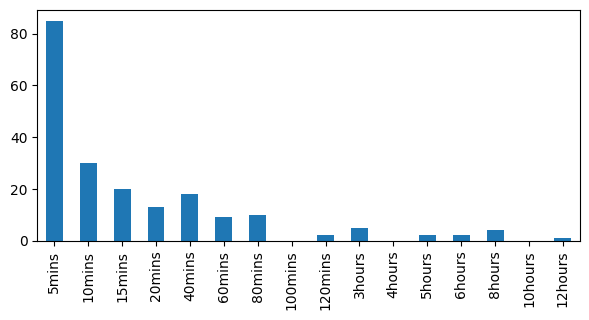

In [529]:
branc_box_filedatetimes_df = pandas.read_pickle("brancol_box_filedatetimes.pickle")

brancol_trip1_startend = (
    parser.parse("2024-01-05 16:14:42Z"),
    parser.parse("2024-01-26 01:35:17Z"),
)
brancol_trip2_startend = (
    parser.parse("2024-02-03 17:16:47Z"),
    parser.parse("2024-02-26 23:32:03Z") + timedelta(hours=7.0966),
)
brancol_trip3_startend = (
    parser.parse("2024-03-05 15:26:13Z"),
    parser.parse("2024-04-01 01:21:47Z") + timedelta(hours=8.4725),
)
branc_box_filedatetimes_df.loc[brancol_trip1_startend[0]] = 0
branc_box_filedatetimes_df.loc[brancol_trip3_startend[1]] = 0
branc_box_filedatetimes_df = branc_box_filedatetimes_df.resample(timedelta(minutes=5)).last()
branc_box_filedatetimes_df["trip1"] = (
    branc_box_filedatetimes_df.index > brancol_trip1_startend[0]
) & (branc_box_filedatetimes_df.index < brancol_trip1_startend[1])
branc_box_filedatetimes_df["trip2"] = (
    branc_box_filedatetimes_df.index > brancol_trip2_startend[0]
) & (branc_box_filedatetimes_df.index < brancol_trip2_startend[1])
branc_box_filedatetimes_df["trip3"] = (
    branc_box_filedatetimes_df.index > brancol_trip3_startend[0]
) & (branc_box_filedatetimes_df.index < brancol_trip3_startend[1])
branc_box_filedatetimes_df["cam1"] = branc_box_filedatetimes_df["cam1"].fillna(0)
branc_box_filedatetimes_df["cam2"] = branc_box_filedatetimes_df["cam2"].fillna(0)
branc_box_filedatetimes_df["bothcams"] = branc_box_filedatetimes_df.apply(
    lambda x: 1 if x.cam1 > 0 and x.cam2 > 0 else 0, axis=1
)
sr = sunrisesunset[["sunrise"]]
sr["a"] = 1
sr = sr.set_index("sunrise")
sr = sr.resample(timedelta(minutes=5)).last()
ss = sunrisesunset[["sunset"]]
ss["b"] = 0
ss = ss.set_index("sunset")
ss = ss.resample(timedelta(minutes=5)).last()
srss = sr.join(ss, how="outer")
# sj['a'] = sj['a'].fillna(value=None)
# sj['b'] = sj['b'].fillna(value=None)
# display(sj)

srss["sunup"] = srss.apply(
    lambda x: x["a"] if pandas.notna(x["a"]) else x["b"] if pandas.notna(x["b"]) else None, axis=1
)
srss["sunup"] = srss["sunup"].ffill()

branc_box_filedatetimes_df = branc_box_filedatetimes_df.join(srss["sunup"])
# display_full(branc_box_filedatetimes_df)

stp_box_filedatetimes_df = pandas.read_pickle("stpatrick_box_filedatetimes.pickle")

stpatrick_trip1_startend = (
    parser.parse("2024-01-03 13:22:25Z"),
    parser.parse("2024-01-28 06:40:04Z"),
)
stpatrick_trip2_startend = (
    parser.parse("2024-02-03 13:44:11Z"),
    parser.parse("2024-02-28 03:42:55Z") + timedelta(hours=1.578),
)
stp_box_filedatetimes_df.loc[stpatrick_trip1_startend[0]] = 0
stp_box_filedatetimes_df.loc[stpatrick_trip2_startend[1]] = 0
stp_box_filedatetimes_df = stp_box_filedatetimes_df.resample(timedelta(minutes=5)).last()

stp_box_filedatetimes_df["trip1"] = (
    stp_box_filedatetimes_df.index > stpatrick_trip1_startend[0]
) & (stp_box_filedatetimes_df.index < stpatrick_trip1_startend[1])
stp_box_filedatetimes_df["trip2"] = (
    stp_box_filedatetimes_df.index > stpatrick_trip2_startend[0]
) & (stp_box_filedatetimes_df.index < stpatrick_trip2_startend[1])
stp_box_filedatetimes_df["trip3"] = False
stp_box_filedatetimes_df["cam1"] = stp_box_filedatetimes_df["cam1"].fillna(0)
stp_box_filedatetimes_df["cam2"] = stp_box_filedatetimes_df["cam2"].fillna(0)
stp_box_filedatetimes_df["bothcams"] = stp_box_filedatetimes_df.apply(
    lambda x: 1 if x.cam1 > 0 and x.cam2 > 0 else 0, axis=1
)

stp_box_filedatetimes_df = stp_box_filedatetimes_df.join(srss["sunup"])
# display_full(stp_box_filedatetimes_df)


class ReduceOutages:
    def __init__(self):
        self.outages = []
        self.outageStart = None
        self.last = None

    def __call__(self, nx):
        #         print(dir(nx.index))
        #         if nx.Index == parser.parse('2024-02-06 23:25:00+00:00'):
        #             print(nx, self.last)
        if not ((nx.trip1 or nx.trip2 or nx.trip3) and nx.sunup):
            if self.outageStart and self.last is not None:
                self.outages.append(
                    (
                        self.outageStart,
                        nx.Index,
                    )
                )
            self.outageStart = None
            self.last = None
            return
        if self.last is None:
            if nx.bothcams == 0:
                self.outageStart = nx.Index
            self.last = nx
            return
        if self.last.bothcams == 1 and nx.bothcams == 0:
            self.outageStart = nx.Index
        if self.last.bothcams == 0 and nx.bothcams == 1:
            self.outages.append(
                (
                    self.outageStart,
                    nx.Index,
                )
            )
            self.outageStart = None
        self.last = nx


branc_reduce_outages = ReduceOutages()
for i in branc_box_filedatetimes_df.itertuples(index=True, name="a"):
    branc_reduce_outages(i)

stp_reduce_outages = ReduceOutages()
for i in stp_box_filedatetimes_df.itertuples(index=True, name="a"):
    stp_reduce_outages(i)

# put the outages into a resample.first.ffill so that it can be plotted alongside uptime on the very long time graph
tmp = pandas.DataFrame(
    [
        x
        for (o_start, o_end) in branc_reduce_outages.outages
        for x in [
            {"datetime": o_start, "outage": 1, "diff": o_end - o_start},
            {"datetime": o_end, "outage": 0, "diff": pandas.NA},
        ]
    ]
).set_index("datetime")
tmp = tmp.resample(timedelta(minutes=5)).first().ffill()

branc_box_filedatetimes_df["outage"] = tmp["outage"]
branc_box_filedatetimes_df["diff"] = tmp["diff"]
branc_box_filedatetimes_df["outage"] = branc_box_filedatetimes_df["outage"].fillna(0)
# display(branc_box_filedatetimes_df[['bothcams','outage']].plot(figsize=(200,2)))

all_outtages_df = pandas.DataFrame(branc_reduce_outages.outages + stp_reduce_outages.outages)
all_outtages_df["diff"] = all_outtages_df[1] - all_outtages_df[0]
binandlabels = [
    (timedelta(minutes=0), "0mins"),
    (timedelta(minutes=5), "5mins"),
    (timedelta(minutes=10), "10mins"),
    (timedelta(minutes=15), "15mins"),
    (timedelta(minutes=20), "20mins"),
    (timedelta(minutes=40), "40mins"),
    (timedelta(minutes=60), "60mins"),
    (timedelta(minutes=80), "80mins"),
    (timedelta(minutes=100), "100mins"),
    (timedelta(minutes=120), "120mins"),
    (timedelta(hours=3), "3hours"),
    (timedelta(hours=4), "4hours"),
    (timedelta(hours=5), "5hours"),
    (timedelta(hours=6), "6hours"),
    (timedelta(hours=8), "8hours"),
    (timedelta(hours=10), "10hours"),
    (timedelta(hours=12), "12hours"),
]
bins = [i[0] for i in binandlabels]
labels = [i[1] for i in binandlabels][1:]
all_outtages_df["cut"] = pandas.cut(all_outtages_df["diff"], bins, labels=labels)

all_outtages_df.groupby("cut").count()["diff"].plot(kind="bar", figsize=(7, 3), xlabel="")


In [543]:
# try to prove that captain behavior (long outages) accounted for most of the difference
# between videoon/systemon and videoon/daylighton

sunupcount = (
    (
        branc_box_filedatetimes_df["trip1"]
        | branc_box_filedatetimes_df["trip2"]
        | branc_box_filedatetimes_df["trip3"]
    )
    & branc_box_filedatetimes_df["sunup"]
    == 1
).sum()
print("outagecount", (branc_box_filedatetimes_df["outage"] == 1).sum())
print("sunupcount", sunupcount)

print((sunupcount - 1079) / sunupcount)


# branc_box_filedatetimes_df.loc[branc_box_filedatetimes_df['diff'].map(pandas.notna)]
outagecount_minuslongoutages = (
    (branc_box_filedatetimes_df["outage"] == 1)
    & (branc_box_filedatetimes_df["diff"] < timedelta(hours=2))
).sum()

print("outagecount_minuslongoutages", outagecount_minuslongoutages)
# print('sunupcount', ((branc_box_filedatetimes_df['trip1'] | branc_box_filedatetimes_df['trip2'] | branc_box_filedatetimes_df['trip3'] ) & branc_box_filedatetimes_df['sunup'] == 1).sum())
(sunupcount - outagecount_minuslongoutages) / sunupcount

# not compelling. 89% -> 95% is not enough for me
# I expected it to be closer to the 98% (from brancol video uptime with thalos system logs as baseline)

outagecount 1079
sunupcount 9874
0.8907231112011343
outagecount_minuslongoutages 429


0.9565525622847884

In [ ]:
brancol_file_uptime = pandas.read_pickle("brancol_box_filedatetimes.pickle")
brancol_file_uptime = brancol_file_uptime.resample(timedelta(minutes=5)).sum()
branc_list_of_state_changes = brancol_file_uptime.join(
    brancol_file_uptime.shift(1), lsuffix="_next", rsuffix="_prev"
)
# print(dir(branc_list_of_state_changes.index))
branc_list_of_state_changes = branc_list_of_state_changes.loc[branc_list_of_state_changes.index[1:]]


# branc_list_of_state_changes
def newstate(x):
    retA = None
    if x["cam1_prev"] < x["cam1_next"]:
        retA = "up"
    elif x["cam1_prev"] > x["cam1_next"]:
        retA = "down"

    retB = None
    if x["cam2_prev"] < x["cam2_next"]:
        retB = "up"
    elif x["cam2_prev"] > x["cam2_next"]:
        retB = "down"

    if retA and retB and retA != retB:
        return "mixed"
    elif retA:
        return retA
    elif retB:
        return retB
    else:
        return pandas.NA


branc_list_of_state_changes["newstate"] = branc_list_of_state_changes.apply(newstate, axis=1)
# branc_list_of_state_changes
display(branc_list_of_state_changes.loc[pandas.notna(branc_list_of_state_changes["newstate"])])

# brancol_file_uptime.loc[ (brancol_file_uptime['cam1'] == 0) & (brancol_file_uptime['cam2'] == 0) ]
